# CycleGAN

This notebook is a tutorial from [Tensorflow](https://www.tensorflow.org/tutorials/generative/cyclegan). It uses unpaired image to image translation using conditional GAN called CycleGAN. CycleGAN captures the characteristics of 1 image domain, and figure out how these characteristics could be translated into another image domain, all in the absence of paired training examples. 

This is very similar to Pix2Pix, except there's an additional loss function, and the use of unpaired training data. This additional loss function translates one domain to nother without a 1-to-1 mapping between the source and target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer. All you need is the source and target dataset. 

In [33]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

## Load Data

The CycleGAN model is supposed to translate images of horses, to images of zebras. 

In [19]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

## Split Data

In [20]:
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

## Preprocess

Apply random jitter, mirroring (just like from Pix2Pix), and data augmentation to reduce overffiting. 

In [21]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [22]:
def random_crop(image):
    cropped_image = tf.image.random_crop(
        image, size=[IMG_HEIGHT, IMG_WIDTH, 3]
    )
    return cropped_image

In [23]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [24]:
def random_jitter(image):
    # resize to 286 x 286 x 3
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly copping to 256 x 256 x 3
    image = random_crop(image)
    
    # random mirroring
    image = tf.image.random_flip_left_right(image)
    
    return image

In [25]:
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [26]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [27]:
train_horses = train_horses.cache().map(preprocess_image_train, 
                                        num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(preprocess_image_train, 
                                        num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(preprocess_image_test,
                             num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test,
                             num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [28]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

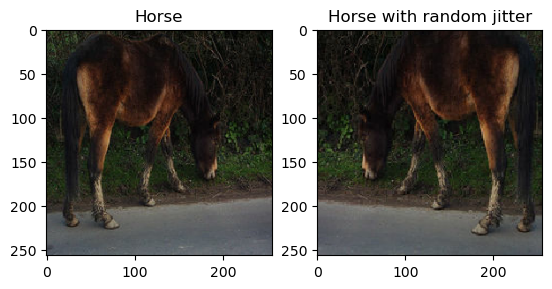

In [29]:
plt.subplot(121)
plt.title("Horse")
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Horse with random jitter")
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

## Import and Reuse Pix2Pix Models

In [34]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

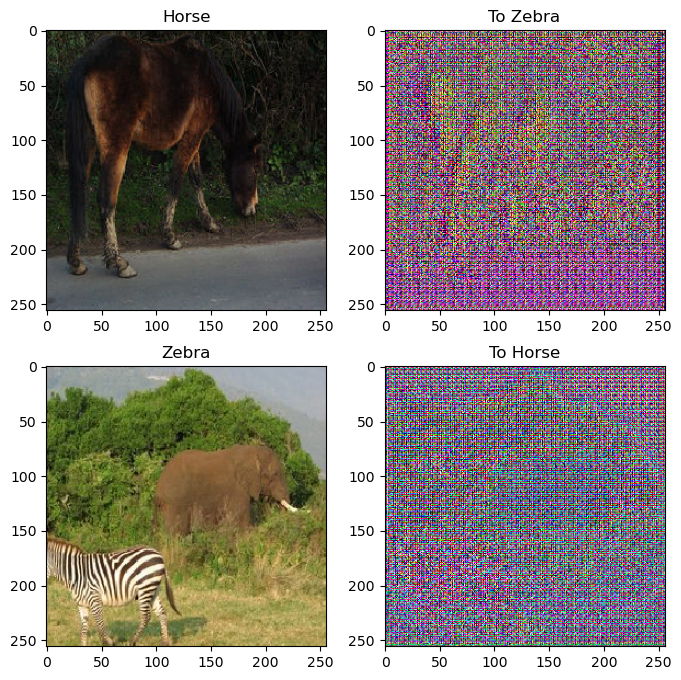

In [35]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ["Horse", "To Zebra", "Zebra", "To Horse"]

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

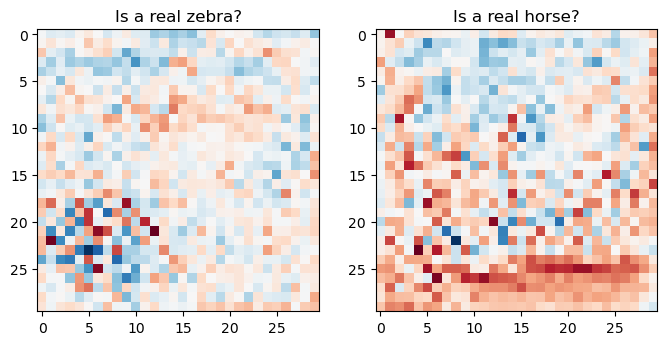

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.title("Is a real zebra?")
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap="RdBu_r")

plt.subplot(122)
plt.title("Is a real horse?")
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap="RdBu_r")

plt.show()

### Loss Functions

There is no paired data to train on, so there is no guarantee that the input `x` and target `y` pair are meaningful during training. In order to enforce that the network learns the correct mapping, the author uses cycle consistency loss. The discriminator loss and the generalor loss are similar to the pix2pix one.

In [53]:
LAMBDA = 10

In [54]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [55]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [65]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. In cycle consistency loss:
- Image X is passed via generator `G` that yields generated image `Y_hat`.
- Generated image `Y_hat` is passed via generator `F` that yields cycled image `X_hat`.
- Mean absolute error is calculated between `X` and `X_hat`.
    - forward cycle consistency loss: X -> G(X) -> F(G(X)) ~ X_hat
    - backward cycle consistency loss: Y -> F(Y) -> G(F(Y)) ~ Y_hat

In [57]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

As shown above, generate `G` is responsible for translating image `X` to image `Y`. Identity loss says that if you fed image `Y` to generator `G`, it should yield the real image `Y` or something close to image `Y`. If you runt eh zebra-to-horse model on a horse or the horse-to-zebra model on the zebra, it should not modify the image much since the image already contains the target class.

> Identity_loss = |G(Y) - Y| + |F(X) - X|

In [58]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and discriminators.

In [59]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Checkpoints

In [60]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                          generator_f=generator_f,
                          discriminator_x=discriminator_x,
                          discriminator_y=discriminator_y,
                          generator_g_optimizer=generator_g_optimizer,
                          generator_f_optimizer=generator_f_optimizer,
                          discriminator_x_optimizer=discriminator_x_optimizer,
                          discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, resotre the latest checkpoint
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

## Train

In [61]:
EPOCHS = 10

In [62]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    title = ["Input Image", "Predicted Image"]
    
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        
        # getting the pixel values between [0, 1] to plot it
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
        
    plt.show()

The training loop consists of:
- Getting predictions
- Calculating the loss
- Calculating the gradients using backpropogation
- Applying the gradients to the optimizer

In [67]:
@tf.function
def train_step(real_x, real_y):
    # persistent=True b/c the tape is used for than once to calculate the gradients
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used to identity loss
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                         generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss,
                                         generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss,
                                             discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss,
                                             discriminator_y.trainable_variables)
    
    # apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                             generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                             generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                 discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                 discriminator_y.trainable_variables))

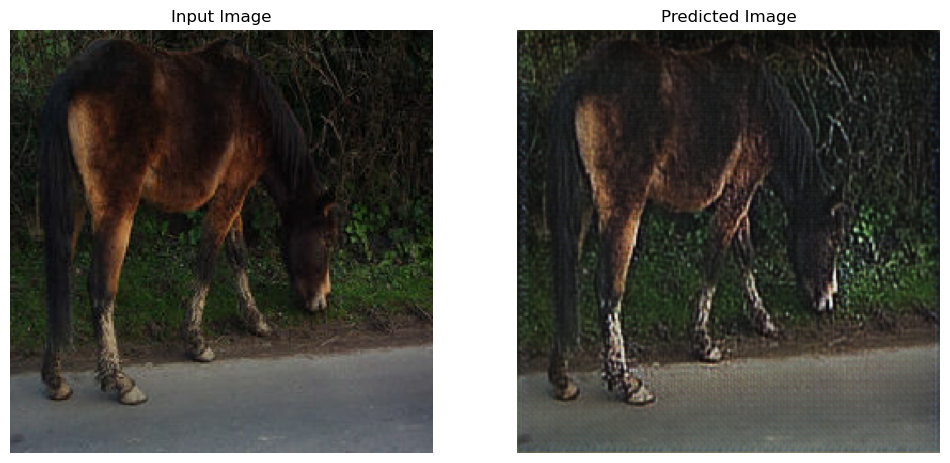

Time taken for epoch 1 is 4964.343761444092 sec

................

KeyboardInterrupt: 

In [68]:
for epoch in range(EPOCHS):
    start = time.time()
    
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n+=1
        
    clear_output(wait=True)
    
    # using a consistent image (sample_horse) so that the progress of the model is clearly visible
    generate_images(generator_g, sample_horse)
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}")
    
    print(f"Time taken for epoch {epoch + 1} is {time.time() - start} sec\n")
                  

## Test

In [ ]:
# run the trained model on the test dataset
for inp in test_horses.take(5):
    generate_images(generator_g, inp)